In [0]:
# Samhitha Kolla and Umar Alkafaween
import pandas as pd
import numpy as np

np.random.seed(237)

In [0]:
# load data
all_data = pd.read_excel('./all_data.xlsx', sheet_name=None, header=0)

In [0]:
# assign each sheet into a variable
team_stats = all_data.get('Team Stats')
playoff_games = all_data.get('Playoff Games')
player_stats = all_data.get('Player Stats')

# delete no longer needed variables to save memory
del all_data

In [0]:
# create a hash with team names and ids to be able to reference teams by their ids
team_ids = {}
for index, row in team_stats.iterrows():
  team_ids[row['Team Name']] = row['Team ID']

In [0]:
# add team ids to playoff games sheet
home_team_ids = []
away_team_ids = []
for index, row in playoff_games.iterrows():
  home_team_ids.append(team_ids[row['Home Team']])
  away_team_ids.append(team_ids[row['Away Team']])

playoff_games.insert(5, 'Home Team ID', home_team_ids)
playoff_games.insert(8, 'Away Team ID', away_team_ids)

# delete no longer needed variables to save memory
del home_team_ids, away_team_ids

In [0]:
# add home and away team stats to the playoffs sheet
team_stats_length = len(team_stats.columns)
new_columns = [[] for x in range(2 * team_stats_length)]
for index, game in playoff_games.iterrows():
  home_team = team_stats.loc[(team_stats['Year'] == game['Year']) & (team_stats['Team ID'] == game['Home Team ID'])].iloc[0]
  away_team = team_stats.loc[(team_stats['Year'] == game['Year']) & (team_stats['Team ID'] == game['Away Team ID'])].iloc[0]
  for i in range(len(home_team)):
    new_columns[i].append(home_team[i])
    new_columns[i + team_stats_length].append(away_team[i])

team_stats_header = team_stats.columns.to_list()
for i in range(len(team_stats_header)):
  playoff_games.insert(len(playoff_games.columns), 'Home Team ' + team_stats_header[i], new_columns[i])
for i in range(len(team_stats_header)):
  playoff_games.insert(len(playoff_games.columns), 'Away Team ' + team_stats_header[i], new_columns[i + team_stats_length])

# delete no longer needed variables to save memory
del team_stats_length, new_columns, team_stats_header

In [0]:
# delete unnecessary columns from playoff games
playoff_games = playoff_games.drop(labels=['Round', 'Home Team', 'Home Team Score', 'Home Team Year', 'Home Team Team ID', 'Home Team Team Name', 'Home Team Games Played', 'Home Team Minutes Played', 'Away Team', 'Away Team Score', 'Away Team Year', 'Away Team Team ID', 'Away Team Team Name', 'Away Team Games Played', 'Away Team Minutes Played'], axis=1)

In [0]:
from sklearn.preprocessing import OneHotEncoder
round_categories = ['Conference First Round', 'Conference Semifinals', 'Conference Finals', 'Finals']
round_labels_ohe = OneHotEncoder(categories=[round_categories], sparse=False, dtype=np.int64)
rows = round_labels_ohe.fit_transform(playoff_games[['Round Without Conference']])
rounds_binary = pd.DataFrame(rows, columns=round_categories)
playoff_games = playoff_games.join(rounds_binary)

# delete no longer needed variables to save memory
del round_categories, round_labels_ohe, rows, rounds_binary

In [0]:
# replace game number in series with two new features: number of wins opponent needs to win the series for both home and away teams
subset = playoff_games[['Year', 'Round Without Conference', 'Game Number in Series', 'Home Team ID', 'Away Team ID', 'Home Team Won']]
home_opponent_wins_until_advance = []
away_opponent_wins_until_advance = []

home_opponent = 0
away_opponent = 0
last_home_team_id = None
for index, row in subset.iterrows():
  year = row['Year']
  curRound = row['Round Without Conference']
  game_number = row['Game Number in Series']
  home_team_id = row['Home Team ID']
  home_team_won = row['Home Team Won']
  if game_number == 1:
    last_home_team_id = home_team_id
    best_of = 3 if year < 2003 and curRound == 'Conference First Round' else 4
    home_opponent = best_of
    away_opponent = best_of
  if home_team_id != last_home_team_id:
    home_opponent, away_opponent = away_opponent, home_opponent
    last_home_team_id = home_team_id
  home_opponent_wins_until_advance.append(home_opponent)
  away_opponent_wins_until_advance.append(away_opponent)
  if home_team_won == 'YES':
    away_opponent -= 1
  else:
    home_opponent -= 1

playoff_games.insert(len(playoff_games.columns), 'Home Team Opponent Wins To Advance', home_opponent_wins_until_advance)
playoff_games.insert(len(playoff_games.columns), 'Away Team Opponent Wins To Advance', away_opponent_wins_until_advance)

# delete no longer needed variables to save memory
del subset, home_opponent_wins_until_advance, away_opponent_wins_until_advance, home_opponent, away_opponent, last_home_team_id

In [0]:
# replace game date with two features: number of days since last game for each team
import time

subset = playoff_games[['Year', 'Round Without Conference', 'Game Number in Series', 'Game Date', 'Home Team ID', 'Away Team ID']]
subset.insert(0, 'Order', range(0, len(subset)))
round_numerical_hash = { 'Conference First Round': 1, 'Conference Semifinals': 2, 'Conference Finals': 3, 'Finals': 4 }
round_numerical_values = []
for index, row in subset.iterrows():
  round_numerical_values.append(round_numerical_hash[row['Round Without Conference']])
subset.insert(len(subset.columns), 'Round Numerical Value', round_numerical_values)

del round_numerical_hash, round_numerical_values

subset = subset.drop(labels=['Round Without Conference'], axis=1)
subset = subset.sort_values(by=['Year', 'Round Numerical Value'])

home_team_last_played = []
away_team_last_played = []

last_year = None
team_last_game = {}
pattern = '%Y-%m-%d'
for index, row in subset.iterrows():
  year = row['Year']
  round_number = row['Round Numerical Value']
  game_number = row['Game Number in Series']
  home_team_id = row['Home Team ID']
  away_team_id = row['Away Team ID']
  game_date = row['Game Date']
  if year != last_year:
    team_last_game = {}
    last_year = year
  game_epoch = int(time.mktime(time.strptime(game_date, pattern)))
  if game_number == 1 and round_number == 1:
    # set last played to 5 days for the first game of the playoffs
    home_days_since_last_played = 5
    away_days_since_last_played = 5
  else:
    home_days_since_last_played = (game_epoch - team_last_game[home_team_id]) / 3600 / 24
    away_days_since_last_played = (game_epoch - team_last_game[away_team_id]) / 3600 / 24

  team_last_game[home_team_id] = game_epoch
  team_last_game[away_team_id] = game_epoch

  home_team_last_played.append(home_days_since_last_played)
  away_team_last_played.append(away_days_since_last_played)

subset.insert(len(subset.columns), 'Home Team Days Since Last Played', home_team_last_played)
subset.insert(len(subset.columns), 'Away Team Days Since Last Played', away_team_last_played)
subset.sort_values(by=['Order'])

playoff_games = playoff_games.join(subset[['Home Team Days Since Last Played', 'Away Team Days Since Last Played']])

del subset, home_team_last_played, away_team_last_played, last_year, team_last_game, pattern

In [0]:
# delete more columns from playoff games - we might need these, that is why they are in a different statement
playoff_games = playoff_games.drop(labels=['Year', 'Round Without Conference', 'Game Number in Series', 'Game Date', 'Home Team ID', 'Away Team ID'], axis=1)

In [0]:
# ranks = ["Home Team Games Played Rank", "Home Team Wins Rank", "Home Team Losses Rank", "Home Team Win Percentage Rank", "Home Team Minutes Played Rank", "Home Team Field Goals Made Rank", "Home Team Field Goals Attempted Rank", "Home Team Field Goals Made Percentage Rank", "Home Team 3Pts Made Rank", "Home Team 3Pts Attempted Rank", "Home Team 3Pts Made Percentage Rank", "Home Team Free Throws Made Rank", "Home Team Free Throws Attempted Rank", "Home Team Free Throws Made Percentage Rank", "Home Team Offensive Rebounds Rank", "Home Team Defensive Rebounds Rank", "Home Team Rebounds Rank", "Home Team Assists Rank", "Home Team Turnovers Rank", "Home Team Steals Rank", "Home Team Blocks Rank", "Home Team Blocks Against Rank", "Home Team Personal Fouls Rank", "Home Team Personal Fouls Drawn Rank", "Home Team Points Rank", "Home Team Plus Minus Rank", "Away Team Games Played Rank", "Away Team Wins Rank", "Away Team Losses Rank", "Away Team Win Percentage Rank", "Away Team Minutes Played Rank", "Away Team Field Goals Made Rank", "Away Team Field Goals Attempted Rank", "Away Team Field Goals Made Percentage Rank", "Away Team 3Pts Made Rank", "Away Team 3Pts Attempted Rank", "Away Team 3Pts Made Percentage Rank", "Away Team Free Throws Made Rank", "Away Team Free Throws Attempted Rank", "Away Team Free Throws Made Percentage Rank", "Away Team Offensive Rebounds Rank", "Away Team Defensive Rebounds Rank", "Away Team Rebounds Rank", "Away Team Assists Rank", "Away Team Turnovers Rank", "Away Team Steals Rank", "Away Team Blocks Rank", "Away Team Blocks Against Rank", "Away Team Personal Fouls Rank", "Away Team Personal Fouls Drawn Rank", "Away Team Points Rank", "Away Team Plus Minus Rank"]
# playoff_games_adjusted = playoff_games.drop(labels=ranks, axis=1)

In [0]:
# rearrange columns of playoff games to place label at the end
label_index = playoff_games.columns.get_loc("Home Team Won")
cols = playoff_games.columns.tolist()
cols = [cols[label_index]] + cols[:label_index] + cols[(label_index + 1):]
playoff_games = playoff_games[cols]

# delete no longer needed variables to save memory
del cols

In [0]:
playoff_games

,Home Team Won,Home Team Wins,Home Team Losses,Home Team Win Percentage,Home Team Field Goals Made,Home Team Field Goals Attempted,Home Team Field Goals Made Percentage,Home Team 3Pts Made,Home Team 3Pts Attempted,Home Team 3Pts Made Percentage,Home Team Free Throws Made,Home Team Free Throws Attempted,Home Team Free Throws Made Percentage,Home Team Offensive Rebounds,Home Team Defensive Rebounds,Home Team Rebounds,Home Team Assists,Home Team Turnovers,Home Team Steals,Home Team Blocks,Home Team Blocks Against,Home Team Personal Fouls,Home Team Personal Fouls Drawn,Home Team Points,Home Team Plus Minus,Home Team Games Played Rank,Home Team Wins Rank,Home Team Losses Rank,Home Team Win Percentage Rank,Home Team Minutes Played Rank,Home Team Field Goals Made Rank,Home Team Field Goals Attempted Rank,Home Team Field Goals Made Percentage Rank,Home Team 3Pts Made Rank,Home Team 3Pts Attempted Rank,Home Team 3Pts Made Percentage Rank,Home Team Free Throws Made Rank,Home Team Free Throws Attempted Rank,Home Team Free Throws Made Percentage Rank,Home Team Offensive Rebounds Rank,...,Away Team Blocks,Away Team Blocks Against,Away Team Personal Fouls,Away Team Personal Fouls Drawn,Away Team Points,Away Team Plus Minus,Away Team Games Played Rank,Away Team Wins Rank,Away Team Losses Rank,Away Team Win Percentage Rank,Away Team Minutes Played Rank,Away Team Field Goals Made Rank,Away Team Field Goals Attempted Rank,Away Team Field Goals Made Percentage Rank,Away Team 3Pts Made Rank,Away Team 3Pts Attempted Rank,Away Team 3Pts Made Percentage Rank,Away Team Free Throws Made Rank,Away Team Free Throws Attempted Rank,Away Team Free Throws Made Percentage Rank,Away Team Offensive Rebounds Rank,Away Team Defensive Rebounds Rank,Away Team Rebounds Rank,Away Team Assists Rank,Away Team Turnovers Rank,Away Team Steals Rank,Away Team Blocks Rank,Away Team Blocks Against Rank,Away Team Personal Fouls Rank,Away Team Personal Fouls Drawn Rank,Away Team Points Rank,Away Team Plus Minus Rank,Conference First Round,Conference Semifinals,Conference Finals,Finals,Home Team Opponent Wins To Advance,Away Team Opponent Wins To Advance,Home Team Days Since Last Played,Away Team Days Since Last Played
0,YES,69,13,0.841,40.0,84.4,0.473,6.4,17.1,0.373,16.8,22.5,0.747,15.1,30.0,45.1,26.1,13.5,8.7,4.0,3.5,19.7,0.2,103.1,10.8,1,1,1,1,29,1,3,3,12,11,6,26,27,12,3,...,5.1,4.5,24.1,0.2,103.1,8.8,1,2,2,2,15,4,27,1,27,29,8,1,2,3,28,8,18,1,12,3,12,10,28,6,2,2,0,0,0,1,4,4,4.0,3.0
1,YES,69,13,0.841,40.0,84.4,0.473,6.4,17.1,0.373,16.8,22.5,0.747,15.1,30.0,45.1,26.1,13.5,8.7,4.0,3.5,19.7,0.2,103.1,10.8,1,1,1,1,29,1,3,3,12,11,6,26,27,12,3,...,5.1,4.5,24.1,0.2,103.1,8.8,1,2,2,2,15,4,27,1,27,29,8,1,2,3,28,8,18,1,12,3,12,10,28,6,2,2,0,0,0,1,4,3,3.0,3.0
2,YES,64,18,0.780,38.2,75.8,0.504,4.1,11.0,0.370,22.7,29.5,0.769,10.8,29.4,40.2,26.8,15.4,9.1,5.1,4.5,24.1,0.2,103.1,8.8,1,2,2,2,15,4,27,1,27,29,8,1,2,3,28,...,4.0,3.5,19.7,0.2,103.1,10.8,1,1,1,1,29,1,3,3,12,11,6,26,27,12,3,4,2,2,2,7,25,2,3,7,1,1,0,0,0,1,2,4,2.0,2.0
3,YES,64,18,0.780,38.2,75.8,0.504,4.1,11.0,0.370,22.7,29.5,0.769,10.8,29.4,40.2,26.8,15.4,9.1,5.1,4.5,24.1,0.2,103.1,8.8,1,2,2,2,15,4,27,1,27,29,8,1,2,3,28,...,4.0,3.5,19.7,0.2,103.1,10.8,1,1,1,1,29,1,3,3,12,11,6,26,27,12,3,4,2,2,2,7,25,2,3,7,1,1,0,0,0,1,2,3,2.0,2.0
4,NO,64,18,0.780,38.2,75.8,0.504,4.1,11.0,0.370,22.7,29.5,0.769,10.8,29.4,40.2,26.8,15.4,9.1,5.1,4.5,24.1,0.2,103.1,8.8,1,2,2,2,15,4,27,1,27,29,8,1,2,3,28,...,4.0,3.5,19.7,0.2,103.1,10.8,1,1,1,1,29,1,3,3,12,11,6,26,27,12,3,4,2,2,2,7,25,2,3,7,1,1,0,0,0,1,2,2,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,YES,53,29,0.646,42.3,90.6,0.467,11.0,30.7,0.359,19.0,23.3,0.814,11.8,36.2,48.0,23.0,13.8,6.7,5.0,5.1,20.4,20.7,114.7,

In [0]:
playoff_games['Home Team Won'] = playoff_games['Home Team Won'].map({ 'YES': 1, 'NO': 0 })


Text(0, 0.5, 'Cumulative explained variance')

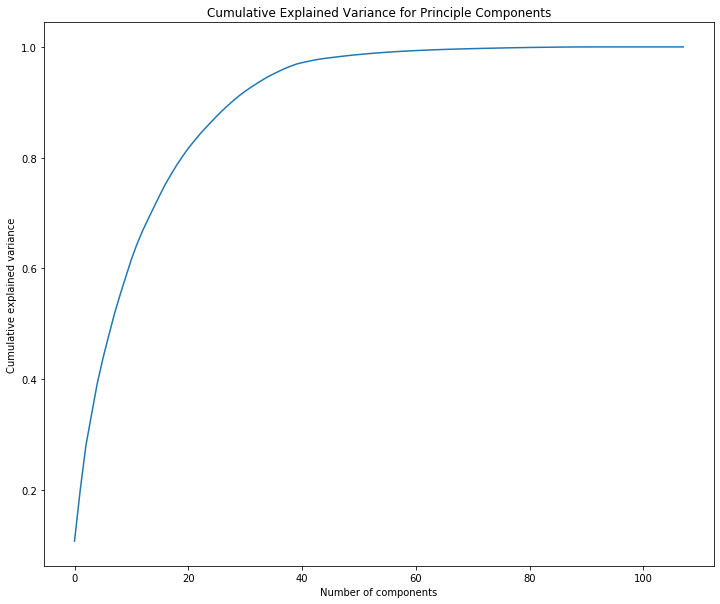

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

X = playoff_games.drop(['Home Team Won'], axis = 1)
Y = playoff_games['Home Team Won']
Y = [[el] for el in Y]

scaler = MinMaxScaler()
X_adjusted = scaler.fit_transform(X)

pca_all = PCA(n_components=108)
pca_all.fit(X_adjusted)

plt.figure(figsize=(12, 10))
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.title('Cumulative Explained Variance for Principle Components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [0]:
np.cumsum(pca_all.explained_variance_ratio_)[65]

0.9954310515642413

In [0]:
input_dim = 65

pca = PCA(n_components=input_dim)
X_pca = pca.fit_transform(X_adjusted)
data = np.hstack([X_pca, Y])
data_rounded = np.around(data, 3)

indices = np.random.choice(data_rounded.shape[0], round(data_rounded.shape[0] * 0.2), replace=False)
test = data_rounded[indices]
train = np.delete(data_rounded, indices, axis=0)

X_train = train[:,:input_dim]
Y_train = train[:, input_dim]

X_test = test[:,:input_dim]
Y_test = test[:, input_dim]

In [0]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

k = 13
knn_cl = KNeighborsClassifier(n_neighbors=k)
knn_cl.fit(X_train, Y_train)
predictions = knn_cl.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, predictions)* 100)

Accuracy: 60.810810810810814


In [0]:
from sklearn.ensemble import BaggingClassifier
k = 13
bagging_cl = BaggingClassifier(KNeighborsClassifier(n_neighbors=k), n_estimators=10)
bagging_cl.fit(X_train, Y_train)
predictions = bagging_cl.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, predictions)* 100)

Accuracy: 62.16216216216216


In [0]:
# %tensorflow_version 2.x

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import regularizers

In [0]:
batch_size = 10
epochs = 250
epochs_in_graph = 150
lr = 0.0005
patience = 75
dropout = 0.2
verbose = 0
l1_reg = 0.001
l2_reg = 0.001

model_name = "best_model_improved"
model_file_name = model_name + '.h5'

model = Sequential()
model.add(Dense(8, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), activity_regularizer=regularizers.l1(l1_reg)))
model.add(Dropout(dropout))
model.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), activity_regularizer=regularizers.l1(l1_reg)))
model.add(Dense(1, activation='sigmoid'))
adam = optimizers.Adam(lr=lr)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
es = EarlyStopping(monitor='val_acc', mode='max', verbose=verbose, patience=patience)
mc = ModelCheckpoint(model_file_name, monitor='val_acc', mode='max', verbose=verbose, save_best_only=True)
historybi = model.fit(x=X_train, y=Y_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_split=0.25, verbose=verbose, callbacks=[es, mc])

saved_model = load_model(model_file_name)

_, accuracy = saved_model.evaluate(X_train, Y_train, batch_size=batch_size)
print('Accuracy: %.2f' % (accuracy*100))

_, accuracy = saved_model.evaluate(X_test, Y_test, batch_size=batch_size)
print('Accuracy: %.2f' % (accuracy*100))

1480/1480 [==============================] - 2s 1ms/step
Accuracy: 73.24
370/370 [==============================] - 0s 266us/step
Accuracy: 62.16


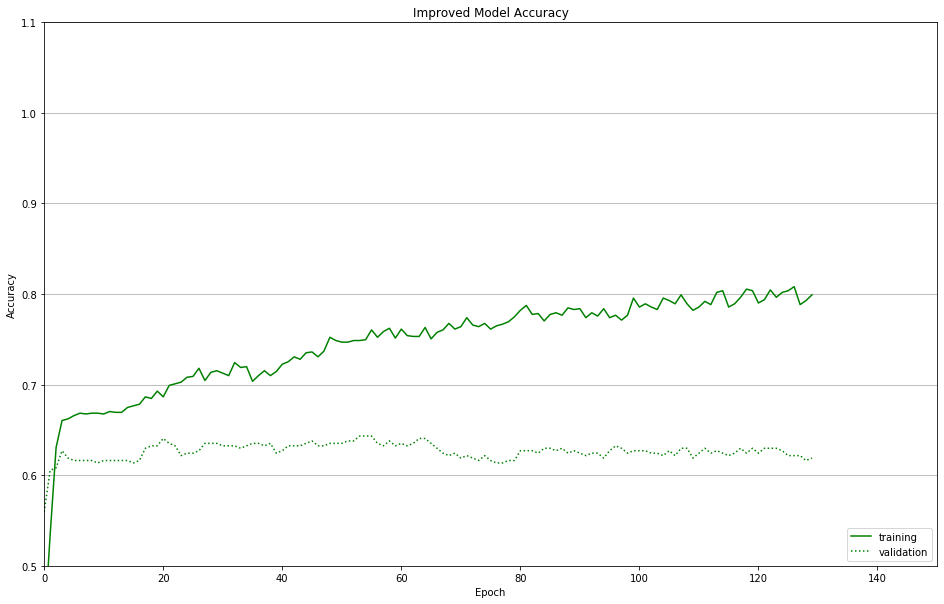

In [0]:
# summarize history for accuracy
fig = plt.figure(figsize=(16, 10))
plt.axis([0, epochs_in_graph, 0.5, 1.1])
plt.grid(axis='y', linestyle='-')
plt.plot(historybi.history['acc'], '-g')
plt.plot(historybi.history['val_acc'], ':g')
plt.title('Improved Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [0]:
# from sklearn.model_selection import GridSearchCV
# rfc = RandomForestClassifier(n_estimators=100)

# param_grid = {   
#   'max_features': [8, 9, 10, 11, 15],
#   'max_depth': [2, 4, 6, 7, 8, 9, 10],
#   'min_samples_leaf': [8, 9, 10, 13],
#   'min_samples_split': [6, 8, 10, 12]
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, scoring='accuracy', n_jobs=-1, verbose=1)
# CV_rfc.fit(X_train, Y_train)
# print (CV_rfc.best_params_)

In [0]:
from sklearn.ensemble import RandomForestClassifier

max_depth = 6
min_samples_leaf = 13
min_samples_split = 10
max_features = 15
n_estimators = 300

rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=max_depth,
                             min_samples_leaf=min_samples_leaf,
                             min_samples_split=min_samples_split,
                             max_features=max_features,
                             n_estimators=n_estimators)
rfc.fit(X_train, Y_train)
predictions = rfc.predict(X_train)
print("Accuracy:", metrics.accuracy_score(Y_train, predictions)* 100)
predictions = rfc.predict(X_test)
print("Accuracy:", metrics.accuracy_score(Y_test, predictions)*100)

Accuracy: 76.41891891891892
Accuracy: 62.972972972972975


In [0]:
xs = []
rf_accs = []
nn_accs = []

for i in range(len(X_train)):
  xs.append(i + 1)

  indices = np.random.choice(len(X_train), i + 1, replace=False)
  X_train_subset = X_train[indices]
  Y_train_subset = Y_train[indices]
  
  predictions = rfc.predict(X_train_subset)
  rf_acc = metrics.accuracy_score(Y_train_subset, predictions) * 100
  rf_accs.append(rf_acc)

  _, accuracy = saved_model.evaluate(X_train_subset, Y_train_subset, batch_size=batch_size, verbose=0)
  nn_acc = accuracy * 100
  nn_accs.append(nn_acc)

In [0]:
plt.figure(figsize=(16, 10))
plt.plot(xs, rf_accs, '1r')
plt.plot(xs, nn_accs, '1g')
plt.grid(axis='y', linestyle='-')
plt.xlabel('Number of predections')
plt.ylabel('Accuracy')
plt.title("Random Forest VS Neural Network Accuracy - Training Data")
plt.legend(['Random Forest', 'Neural Network'], loc='lower right')
plt.axis([0, len(X_train) + 1, 0, 100])
plt.show()

In [0]:
xs = []
rf_accs = []
nn_accs = []

for i in range(len(X_test)):
  xs.append(i + 1)

  indices = np.random.choice(len(X_test), i + 1, replace=False)
  X_test_subset = X_test[indices]
  Y_test_subset = Y_test[indices]
  
  predictions = rfc.predict(X_test_subset)
  rf_acc = metrics.accuracy_score(Y_test_subset, predictions) * 100
  rf_accs.append(rf_acc)

  _, accuracy = saved_model.evaluate(X_test_subset, Y_test_subset, batch_size=batch_size, verbose=0)
  nn_acc = accuracy * 100
  nn_accs.append(nn_acc)

In [0]:
plt.figure(figsize=(16, 10))
plt.plot(xs, rf_accs, '1r')
plt.plot(xs, nn_accs, '1g')
plt.grid(axis='y', linestyle='-')
plt.xlabel('Number of predections')
plt.ylabel('Accuracy')
plt.title("Random Forest VS Neural Network Accuracy - Testing Data")
plt.legend(['Random Forest', 'Neural Network'], loc='lower right')
plt.axis([0, len(X_test) + 1, 0, 100])
plt.show()

In [0]:
predictions = rfc.predict(X_test)
rf_cm = metrics.confusion_matrix(Y_test, predictions)

predictions = saved_model.predict(X_test)
predictions = predictions.round()
nn_cm = metrics.confusion_matrix(Y_test, predictions)

# True positive rate VS True negative rate
pos = np.count_nonzero(Y_test)
neg = len(Y_test) - pos

rf_tnr = rf_cm[0][0] / neg
rf_tpr = rf_cm[1][1] / pos
nn_tnr = nn_cm[0][0] / neg
nn_tpr = nn_cm[1][1] / pos

print(rf_tnr * 100)
print(rf_tpr * 100)
print(nn_tnr * 100)
print(nn_tpr * 100)

12.413793103448276
95.55555555555556
25.517241379310345
85.77777777777777
